# Notebook of an example of computation of propensity score, matching and ATE

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import plotly
import plotly.express as px
import plotly.graph_objs as go

import networkx as nx

import statsmodels.api as sm
import statsmodels.formula.api as smf

import os

In [2]:
GEO_LSOA_PATH = os.getcwd() + '/data/Geo_data/LSOA_2011_London_gen_MHW.shp'
TESCO_PATH = os.getcwd() + '/data/Area_level_data/year_lsoa_grocery.csv'
SOCIO_ECO_LSOA_PATH = os.getcwd() + '/data/lsoa-data.csv'

In [3]:
def load_merge_clean_data(TESCO_PATH, SOCIO_ECO_LSOA_PATH, GEO_LSOA_PATH):
    '''
    This function load the different datasets used for the analysis,
    clean and merge those datasets together to obtain as an output one single panda dataframe
    with the socio-economic, the Tesco and the geography information of each LSOA
    '''
    # load the data with the geography information of each LSOA
    map_df = gpd.read_file(GEO_LSOA_PATH)
    # set the index of this dataframe to the code of each LSOA to facilitate the merge of the dataframes
    map_df.index = map_df['LSOA11CD']
    
    # load the data with the Tesco information of each LSOA
    data_df = pd.read_csv(TESCO_PATH)
    
    # merge the Tesco dataframe with the one with the geo information of the corresponding regions  
    merged_map_df = map_df.join(data_df.set_index('area_id'))
    
    # convert coordinates that are in UTM format into latitude longitude (to plot the results on a map)
    merged_map_df = merged_map_df.to_crs({'init': 'epsg:4326'}) # cause of the warning
    
    # load the data with the socio-economic information of each LSOA
    lsoa_df = pd.read_csv(SOCIO_ECO_LSOA_PATH, encoding = "ISO-8859-1", engine='python')
    # drop the last 2 rows that are full of nan (due to the format of the title of the columns (3 rows))
    lsoa_df.drop(lsoa_df.tail(2).index,inplace=True)
    
    # merge the merged dataframe with  the socio-economic dataframe of the corresponding regions  
    merged_map_lsoa_df = merged_map_df.join(lsoa_df.set_index('Lower Super Output Area'))
    
    # set the index of this dataframe to the name of each LSOA to obtain more comprehensive data
    merged_map_lsoa_df.index = merged_map_lsoa_df['LSOA11NM']
    
    # remove the rows for which we don't have data everywhere 
    # consider the feature of population to determine where we lack some information
    population = np.array((merged_map_lsoa_df['population'])) 
    merged_map_lsoa_df = merged_map_lsoa_df[np.logical_not(np.isnan(population))]
    
    # return this final merged and cleaned dataset
    return merged_map_lsoa_df

In [4]:
df = load_merge_clean_data(TESCO_PATH, SOCIO_ECO_LSOA_PATH, GEO_LSOA_PATH)

//anaconda3/envs/Geopandas_env/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [5]:
df.head()

,LSOA11CD,LSOA11NM,MSOA11CD,MSOA11NM,LAD11CD,LAD11NM,RGN11CD,RGN11NM,USUALRES,HHOLDRES,...,Road Casualties;2012;Slight,Road Casualties;2012;2012 Total,Road Casualties;2013;Fatal,Road Casualties;2013;Serious,Road Casualties;2013;Slight,Road Casualties;2013;2013 Total,Road Casualties;2014;Fatal,Road Casualties;2014;Serious,Road Casualties;2014;Slight,Road Casualties;2014;2014 Total
LSOA11NM,,,,,,,,,,,,,,,,,,,,,
City of London 001A,E01000001,City of London 001A,E02000001,City of London 001,E09000001,City of London,E12000007,London,1465,1465,...,14.0,16.0,0.0,3.0,10.0,13.0,0.0,2.0,10.0,12.0
City of London 001B,E01000002,City of London 001B,E02000001,City of London 001,E09000001,City of London,E12000007,London,1436,1436,...,8.0,9.0,0.0,1.0,5.0,6.0,0.0,0.0,9.0,9.0
City of London 001C,E01000003,City of London 001C,E02000001,City of London 001,E09000001,City of London,E12000007,London,1346,1250,...,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0
City of London 001E,E01000005,City of London 001E,E02000001,City of London 001,E09000001,City of London,E12000007,London,985,985,...,22.0,24.0,0.0,5.0,15.0,20.0,1.0,0.0,20.0,21.0
Barking and Dagenham 016A,E01000006,Barking and Dagenham 016A,E02000017,Barking and Dagenham 016,E09000002,Barking and Dagenham,E12000007,London,1703,1699,...,0.0,0.0,0.0,0.0,4.0,4.0,0.0,0.0,3.0,3.0


# Standardize the features of interest

In [6]:
eco_activ = df['Economic Activity;Employment Rate;2011']
eco_activ_stand = (eco_activ - np.mean(eco_activ))/np.std(eco_activ)

income = df['Household Income, 2011/12;Median Annual Household Income estimate (£)']
income_stand = (income - np.mean(income))/np.std(income)

age = df['avg_age']
age_stand = (age - np.mean(age))/np.std(age)

h_items = df['h_items_norm']
h_items_stand = (h_items - np.mean(h_items))/np.std(h_items)

In [7]:
diversity_feats = ['Ethnic Group;Mixed/multiple ethnic groups (%);2011', 
                   'Ethnic Group;Asian/Asian British (%);2011', 
                   'Ethnic Group;Black/African/Caribbean/Black British (%);2011', 
                   'Ethnic Group;Other ethnic group (%);2011']
h_ethnicity = 0
for feat in diversity_feats:
    val_feat = df[feat]/100
    h_ethnicity += -val_feat * np.log2(val_feat+0.001)
h_ethnicity = h_ethnicity/np.log2(4)

h_ethnicity_stand = (h_ethnicity - np.mean(h_ethnicity))/np.std(h_ethnicity)

In [8]:
stand_df = pd.DataFrame()
stand_df['eco'] = eco_activ_stand
stand_df['income'] = income_stand
stand_df['age'] = age_stand
stand_df['h_items'] = h_items_stand
stand_df['h_ethnicity'] = h_ethnicity_stand
stand_df['h_ethni_bin'] = [1 if eth > np.median(h_ethnicity) else 0 for eth in h_ethnicity]

# Binary propensity score

In [53]:
mod = smf.logit(formula='h_ethni_bin ~  income + age + eco', data=stand_df)

res = mod.fit()

# Extract the estimated propensity scores
stand_df['Propensity_score'] = res.predict()

Optimization terminated successfully.
         Current function value: 0.482198
         Iterations 6


In [54]:
print(res.summary())

                           Logit Regression Results                           
Dep. Variable:            h_ethni_bin   No. Observations:                 4833
Model:                          Logit   Df Residuals:                     4829
Method:                           MLE   Df Model:                            3
Date:                Tue, 08 Dec 2020   Pseudo R-squ.:                  0.3043
Time:                        18:54:42   Log-Likelihood:                -2330.5
converged:                       True   LL-Null:                       -3350.0
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0716      0.038     -1.876      0.061      -0.146       0.003
income        -0.9389      0.064    -14.711      0.000      -1.064      -0.814
age           -0.8760      0.047    -18.757      0.0

# Matching

In [55]:
def are_matching(propensity_score1, propensity_score2, epsilon):
    '''Calculate similarity for instances with given propensity scores'''
    return np.abs(propensity_score1-propensity_score2) < epsilon


def generate_matching_graph(treatment_df, control_df):    
    # Create an empty undirected graph
    G = nx.Graph()

    # Make sure that each control sample is only associated to a single treatment sample
    #control_id_in_graph = []

    # Loop through all the pairs of instances
    for treatment_id, treatment_row in treatment_df.iterrows():
        for control_id, control_row in control_df.iterrows():

            # Calculate the similarity 
            if are_matching(control_row['Propensity_score'],
                                treatment_row['Propensity_score'], 
                                epsilon=0.05):

                # We cannot simply check that a node exists using G.has_node()
                # because both the treatment and control samples can have the same IDs
                #if control_id not in control_id_in_graph: 
                if not G.has_node(control_id):

                    # Add an edge between the two instances weighted with a weight of 1
                    G.add_weighted_edges_from([(treatment_id, control_id, 1)])
                    #control_id_in_graph.append(control_id)

                    # Each treatment can only be associated with a single control sample,
                    # so we break the inner for loop and move to the next treatment sample
                    break 
    return G

In [56]:
PS_df = stand_df

# Separate the treatment and control groups
treatment_df = PS_df[PS_df['h_ethni_bin'] == 1]
control_df = PS_df[PS_df['h_ethni_bin'] == 0]

G = generate_matching_graph(treatment_df, control_df)

matching_list = []
for id_ in G:
    matching_list.append(id_)

balanced_df = PS_df.loc[matching_list]
balanced_df.head()

,eco,income,age,h_items,h_ethnicity,h_ethni_bin,Propensity_score,bottom_top_20
LSOA11NM,,,,,,,,
City of London 001E,-0.409714,-1.025721,-0.162352,-0.182977,0.932069,1,0.762890,1
Barking and Dagenham 013A,-0.690989,-0.693465,-0.277907,1.409702,-0.223168,0,0.740869,0
Barking and Dagenham 016A,-0.444873,0.295365,-1.102792,-0.245228,0.398236,1,0.682145,0
Barking and Dagenham 023B,-0.855067,-0.602548,-0.238872,0.248084,0.068573,0,0.728091,0
Barking and Dagenham 015A,-1.101183,-0.831236,-2.356817,0.420479,1.305387,1,0.958358,1


In [57]:
print("We managed to match {0:.0f} pairs of samples. ".format(balanced_df.shape[0]/2))
print("{0:.0f} samples were not matched to any other sample, which is equivalent to {1:.0f} pairs.".format(
          PS_df.shape[0] - balanced_df.shape[0], 
          (PS_df.shape[0] - balanced_df.shape[0])/2)) 

We managed to match 1081 pairs of samples. 
2671 samples were not matched to any other sample, which is equivalent to 1336 pairs.


# Visualization of the matching

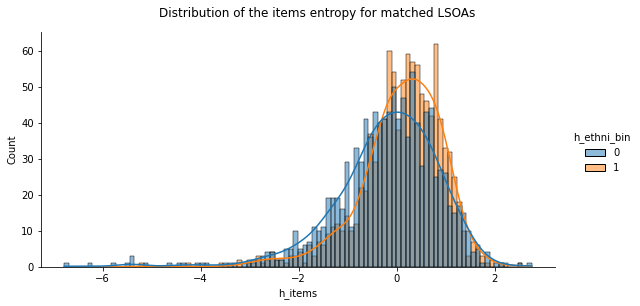

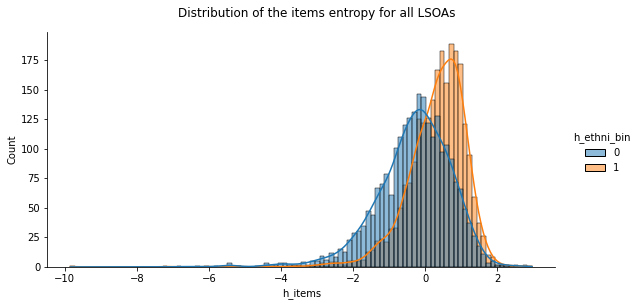

In [58]:
## THIS FEATURE IS NOT PART OF THE COMPUTATION OF THE PROPENSITY SCORE    ##
## AS IT IS THE FEATURE FROM WHICH THE OUTCOME BINARY FEATURE IS COMPUTED ##
## THEREFORE THE DISTRIBUTION SHOULD NOT NECESSARILY OVERLAP MORE ON THE  ##
## MATCHED PAPERS THAN ON ALL THE PAPERS                                  ##

sns.displot(data = balanced_df, x = 'h_items', hue = 'h_ethni_bin', 
            kde = True, fill = True, bins = 100, height = 4, aspect = 2);
plt.suptitle('Distribution of the items entropy for matched LSOAs', fontsize = 12, y = 1.05)
plt.show()

sns.displot(data = PS_df, x = 'h_items', hue = 'h_ethni_bin', 
            kde = True, fill = True, bins = 100, height = 4, aspect = 2);
plt.suptitle('Distribution of the items entropy for all LSOAs', fontsize = 12, y = 1.05)
plt.show()

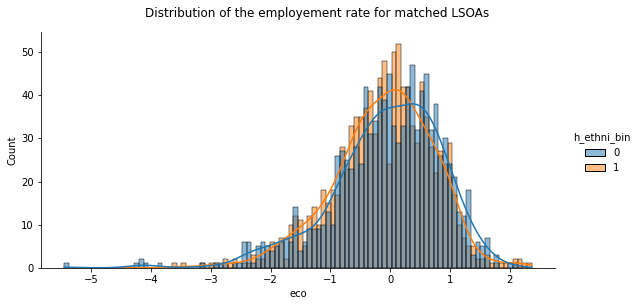

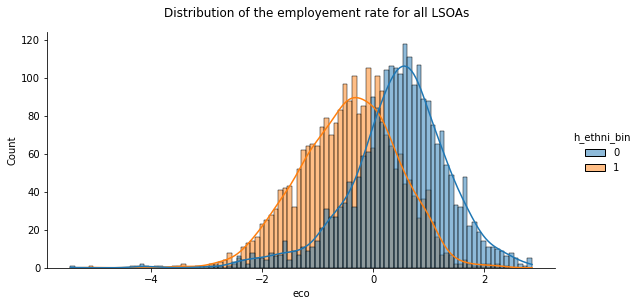

In [59]:
sns.displot(data = balanced_df, x = 'eco', hue = 'h_ethni_bin', 
            kde = True, fill = True, bins = 100, height = 4, aspect = 2);
plt.suptitle('Distribution of the employement rate for matched LSOAs', fontsize = 12, y = 1.05)
plt.show()

sns.displot(data = PS_df, x = 'eco', hue = 'h_ethni_bin', 
            kde = True, fill = True, bins = 100, height = 4, aspect = 2);
plt.suptitle('Distribution of the employement rate for all LSOAs', fontsize = 12, y = 1.05)
plt.show()

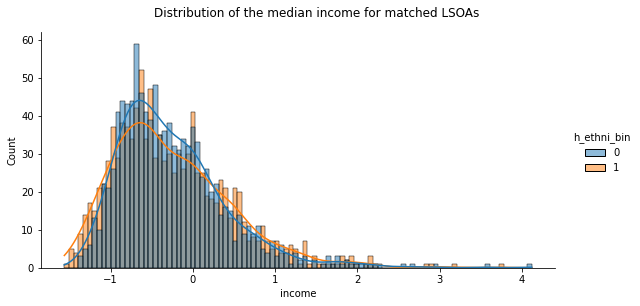

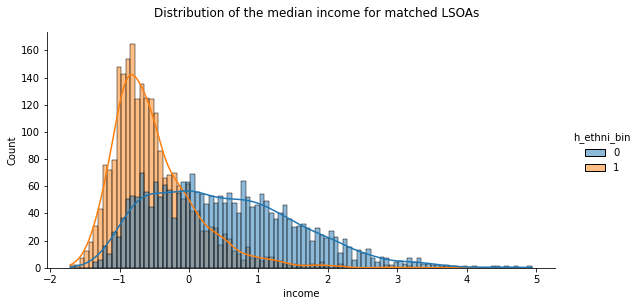

In [60]:
sns.displot(data = balanced_df, x = 'income', hue = 'h_ethni_bin', 
            kde = True, fill = True, bins = 100, height = 4, aspect = 2);
plt.suptitle('Distribution of the median income for matched LSOAs', fontsize = 12, y = 1.05)
plt.show()

sns.displot(data = PS_df, x = 'income', hue = 'h_ethni_bin', 
            kde = True, fill = True, bins = 100, height = 4, aspect = 2);
plt.suptitle('Distribution of the median income for matched LSOAs', fontsize = 12, y = 1.05)
plt.show()

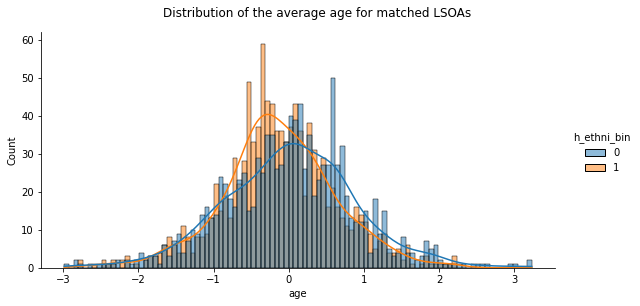

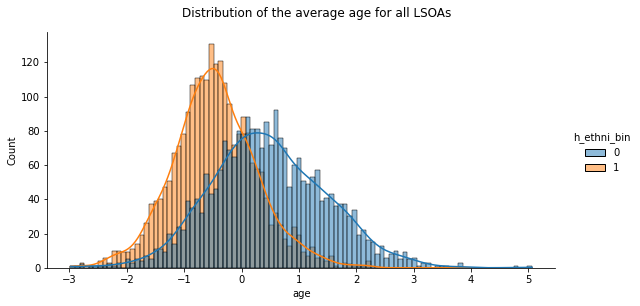

In [61]:
sns.displot(data = balanced_df, x = 'age', hue = 'h_ethni_bin', 
            kde = True, fill = True, bins = 100, height = 4, aspect = 2);
plt.suptitle('Distribution of the average age for matched LSOAs', fontsize = 12, y = 1.05)
plt.show()

sns.displot(data = PS_df, x = 'age', hue = 'h_ethni_bin', 
            kde = True, fill = True, bins = 100, height = 4, aspect = 2);
plt.suptitle('Distribution of the average age for all LSOAs', fontsize = 12, y = 1.05)
plt.show()

# ATE

In [65]:
balanced_df['h_items_bin'] = [1 if item > 0 else 0 for item in balanced_df['h_items']]

In [66]:
matched_treated_df = balanced_df[balanced_df['h_ethni_bin'] == 1]
matched_control_df = balanced_df[balanced_df['h_ethni_bin'] == 0]

In [67]:
def bootstrap_ATE_CI_95(data_treat, data_ctrl, nbr_draws):
    """
    compute the average treatment effect between treated and control set of data with its 95% confidence interval using bootstrap resampling
    """
    
    ATE = np.zeros(nbr_draws)
    data_treat = np.array(data_treat['h_items_bin'])
    data_ctrl = np.array(data_ctrl['h_items_bin'])
    
    assert (data_treat.shape == data_ctrl.shape), "The two sets of data must have the same length"
    
    np.random.seed(42)

    for n in range(nbr_draws):
        indices = np.random.randint(0, len(data_treat), len(data_treat))
        bootstrap_resample_treat = data_treat[indices] 
        bootstrap_rasample_ctrl = data_ctrl[indices]
        ATE[n] = (1/len(bootstrap_resample_treat)) * (bootstrap_resample_treat.sum() - bootstrap_rasample_ctrl.sum())

    return np.mean(ATE), np.nanpercentile(ATE, 2.5), np.nanpercentile(ATE, 97.5), ATE

In [68]:
mean_ATE, CI95_low_ATE, CI95_high_ATE, ATE_dist = bootstrap_ATE_CI_95(matched_treated_df, matched_control_df, 1000)

print('Average Treatment Effect (ATE): {0:.4f} with 95% confidence interval: [{1:.4f}, {2:.4f}]' \
      .format(mean_ATE, CI95_low_ATE, CI95_high_ATE)) 

Average Treatment Effect (ATE): 0.1313 with 95% confidence interval: [0.0925, 0.1739]


# Taking only the bottom and top 20%

In [36]:
quant = np.quantile(stand_df['h_ethnicity'], [0,0.2,0.8,1])
bottom = quant[1]
top = quant[2]
stand_df['bottom_top_20'] = [1 if (eth > top or eth < bottom) else 0 for eth in stand_df['h_ethnicity']]

In [37]:
bottom_top_df = stand_df[stand_df['bottom_top_20'] == 1]

### Propensity score

In [47]:
mod = smf.logit(formula='h_ethni_bin ~  income + age + eco', data=bottom_top_df)

res = mod.fit()

# Extract the estimated propensity scores
bottom_top_df['Propensity_score'] = res.predict()

Optimization terminated successfully.
         Current function value: 0.210318
         Iterations 8


<ipython-input-47-522898437148>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bottom_top_df['Propensity_score'] = res.predict()


In [48]:
print(res.summary())

                           Logit Regression Results                           
Dep. Variable:            h_ethni_bin   No. Observations:                 1934
Model:                          Logit   Df Residuals:                     1930
Method:                           MLE   Df Model:                            3
Date:                Tue, 08 Dec 2020   Pseudo R-squ.:                  0.6966
Time:                        18:53:06   Log-Likelihood:                -406.76
converged:                       True   LL-Null:                       -1340.5
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1960      0.108      1.821      0.069      -0.015       0.407
income        -0.7295      0.168     -4.335      0.000      -1.059      -0.400
age           -1.9832      0.134    -14.762      0.0

In [49]:
PS_df = bottom_top_df

# Separate the treatment and control groups
treatment_df = PS_df[PS_df['h_ethni_bin'] == 1]
control_df = PS_df[PS_df['h_ethni_bin'] == 0]

G = generate_matching_graph(treatment_df, control_df)

matching_list = []
for id_ in G:
    matching_list.append(id_)

balanced_df = PS_df.loc[matching_list]
balanced_df.head()

,eco,income,age,h_items,h_ethnicity,h_ethni_bin,Propensity_score,bottom_top_20
LSOA11NM,,,,,,,,
City of London 001E,-0.409714,-1.025721,-0.162352,-0.182977,0.932069,1,0.875581,1
Bexley 019B,-0.198757,-0.628724,-0.371192,-0.493320,-1.772214,0,0.848530,1
Barking and Dagenham 015A,-1.101183,-0.831236,-2.356817,0.420479,1.305387,1,0.999337,1
Bexley 019A,-0.901946,-1.079381,-0.922080,-0.019071,-1.219553,0,0.986875,1
Barking and Dagenham 015B,-1.816092,-1.007922,-2.376097,1.817213,1.320563,1,0.999830,1


In [50]:
print("We managed to match {0:.0f} pairs of samples. ".format(balanced_df.shape[0]/2))
print("{0:.0f} samples were not matched to any other sample, which is equivalent to {1:.0f} pairs.".format(
          PS_df.shape[0] - balanced_df.shape[0], 
          (PS_df.shape[0] - balanced_df.shape[0])/2)) 

We managed to match 125 pairs of samples. 
1684 samples were not matched to any other sample, which is equivalent to 842 pairs.


## ATE

In [51]:
balanced_df['h_items_bin'] = [1 if item > 0 else 0 for item in balanced_df['h_items']]
matched_treated_df = balanced_df[balanced_df['h_ethni_bin'] == 1]
matched_control_df = balanced_df[balanced_df['h_ethni_bin'] == 0]

In [52]:
mean_ATE, CI95_low_ATE, CI95_high_ATE, ATE_dist = bootstrap_ATE_CI_95(matched_treated_df, matched_control_df, 1000)

print('Average Treatment Effect (ATE): {0:.4f} with 95% confidence interval: [{1:.4f}, {2:.4f}]' \
      .format(mean_ATE, CI95_low_ATE, CI95_high_ATE)) 

Average Treatment Effect (ATE): 0.1579 with 95% confidence interval: [0.0400, 0.2720]
